In [1]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

save_dir = 'plots'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/project/zhiwei/hf78/miniconda3/envs/scf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImprovedECGModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(ImprovedECGModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        self.attention_weights = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )
    def attention(self, lstm_output):
        # lstm_output shape: (batch, seq_len, hidden_size * 2)
        weights = self.attention_weights(lstm_output)  # (batch, seq_len, 1)
        weights = torch.softmax(weights, dim=1)  # (batch, seq_len, 1)
        context = torch.sum(weights * lstm_output, dim=1)  # (batch, hidden_size * 2)
        return context
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size * 2)
        context = self.attention(lstm_out)  # (batch, hidden_size * 2)
        output = self.fc(context)  # (batch, output_size)
        return output

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    best_val_loss = float('inf')
    early_stopping_patience = 10
    no_improvement = 0
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0       
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)           
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()       
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        scheduler.step(avg_val_loss)
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(avg_val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)       
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')       
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stopping triggered")
                break    
    return training_history                

In [4]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_data = pd.read_csv('/project/zhiwei/hf78/ecg/data/ECGModel/mitbih_train.csv')
test_data = pd.read_csv('/project/zhiwei/hf78/ecg/data/ECGModel/mitbih_test.csv')
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val, X_test_new, y_val, y_test_new = train_test_split(
    X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test
)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1)) 

Using device: cuda


In [5]:
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 5
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.LongTensor(y_train)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_val),
    torch.LongTensor(y_val)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_test_new),
    torch.LongTensor(y_test_new)
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)
model = ImprovedECGModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)    
history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    device, epochs
)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)           
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()            
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())    
test_acc = 100. * test_correct / test_total
print(f'\nTest Accuracy: {test_acc:.2f}%')   
print('\nClassification Report:')
print(classification_report(all_labels, all_predictions))    

Epoch 1/50:
Train Loss: 0.3596, Train Acc: 90.69%
Val Loss: 0.2231, Val Acc: 94.05%
Epoch 2/50:
Train Loss: 0.1902, Train Acc: 94.96%
Val Loss: 0.1639, Val Acc: 95.28%
Epoch 3/50:
Train Loss: 0.1513, Train Acc: 95.87%
Val Loss: 0.1229, Val Acc: 96.35%
Epoch 4/50:
Train Loss: 0.1228, Train Acc: 96.55%
Val Loss: 0.1263, Val Acc: 96.63%
Epoch 5/50:
Train Loss: 0.1068, Train Acc: 97.10%
Val Loss: 0.1060, Val Acc: 97.08%
Epoch 6/50:
Train Loss: 0.0951, Train Acc: 97.47%
Val Loss: 0.0953, Val Acc: 97.30%
Epoch 7/50:
Train Loss: 0.0869, Train Acc: 97.63%
Val Loss: 0.0906, Val Acc: 97.57%
Epoch 8/50:
Train Loss: 0.0803, Train Acc: 97.84%
Val Loss: 0.0814, Val Acc: 97.75%
Epoch 9/50:
Train Loss: 0.0734, Train Acc: 97.99%
Val Loss: 0.0855, Val Acc: 97.60%
Epoch 10/50:
Train Loss: 0.0680, Train Acc: 98.07%
Val Loss: 0.0792, Val Acc: 97.98%
Epoch 11/50:
Train Loss: 0.0632, Train Acc: 98.16%
Val Loss: 0.0756, Val Acc: 98.14%
Epoch 12/50:
Train Loss: 0.0581, Train Acc: 98.32%
Val Loss: 0.0737, Val A

In [8]:
labels = {
    0: "Normal",
    1: "Atrial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

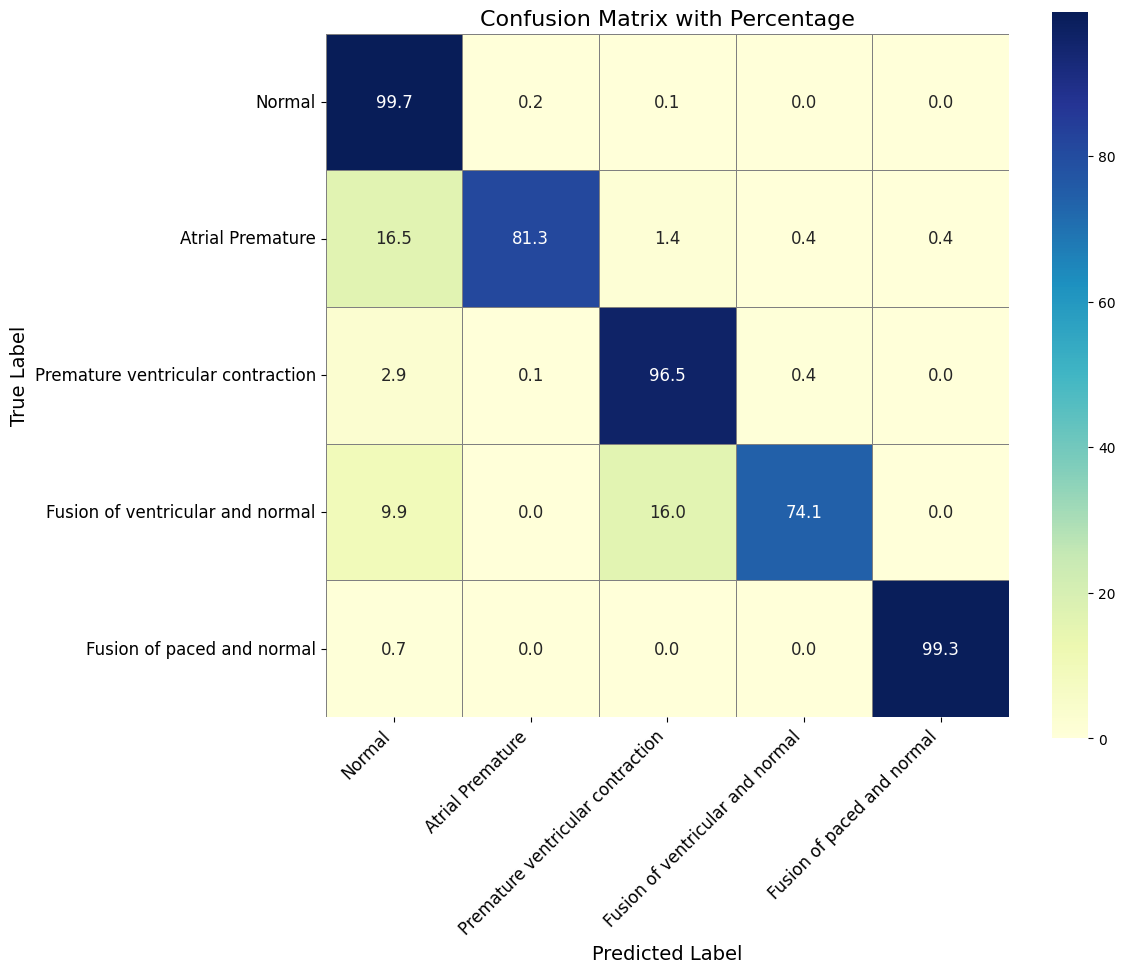

In [10]:
# Assuming you have your predictions and true labels in all_labels and all_predictions
cm = confusion_matrix(all_labels, all_predictions)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  

plt.figure(figsize=(12, 10))
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, square=True, 
            annot_kws={"size": 12}, linewidths=0.5, linecolor="gray")

plt.title("Confusion Matrix with Percentage", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

class_names = list(labels.values())
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha="right", fontsize=12)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

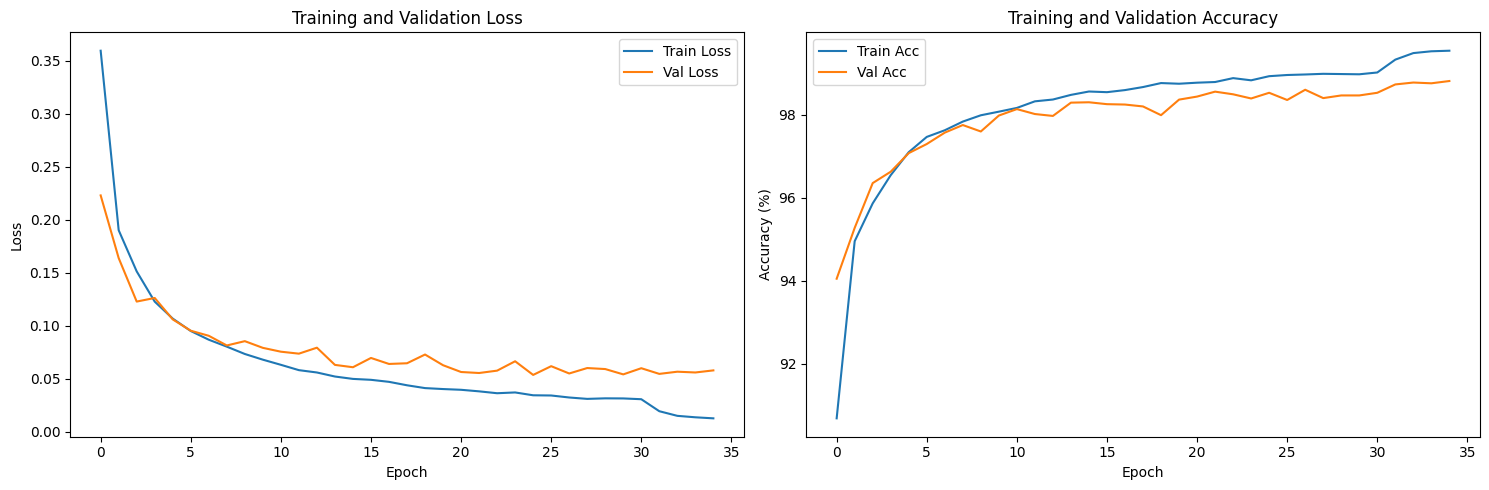

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
history_df = pd.DataFrame({
    'epoch': range(1, len(history['train_loss']) + 1),
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'train_acc': history['train_acc'],
    'val_acc': history['val_acc']
})
history_df.to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)
results = {
    'test_accuracy': test_acc,
    'confusion_matrix': cm.tolist(),
    'training_history': {
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
    }
}